In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
import matplotlib.pyplot as plt
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [3]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

Choose stable tickers + newest tickers on market from S&P 500

In [4]:
# get list of tickers for s&p 500
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
# tickers = list(df['Symbol'].unique())

In [5]:
df.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [6]:
# S&P 500 stocks have been in the index for more than 20 years
df['year'] = pd.to_datetime(df['Date added']).dt.year
len(df[(date.today().year - df['year']) > 20]['Symbol'].unique())

218

In [7]:
tickers = set(df[(date.today().year - df['year']) > 20]['Symbol'])
tickers.update(set(df[df['year'] >= 2020]['Symbol']))

In [8]:
len(tickers)

300

### Collect data

In [40]:
# Download historical closing price data
data = yf.download(tickers, start="2014-01-01", end="2025-07-01", auto_adjust=True)['Close']

[*********************100%***********************]  300 of 300 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2014-01-01 -> 2025-07-01)')
['PPL']: Timeout('Failed to perform, curl: (28) Connection timed out after 10001 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


In [41]:
data.shape

(2890, 300)

In [42]:
data.to_csv('sp300_201401_202507.csv')

### Add base features

In [9]:
df = pd.read_csv('sp300_201401_202507.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [10]:
df.head()

,A,AAPL,ABNB,ABT,ACGL,ADBE,ADI,ADM,ADP,ADSK,...,WMB,WMT,WSM,WST,WY,XEL,XOM,XYZ,YUM,ZBH
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,36.524570,17.173323,NaN,30.464325,18.184349,59.290001,38.541210,31.007017,54.525017,49.250000,...,20.055784,20.850986,22.321127,46.030258,20.068611,19.025341,61.047668,NaN,43.341000,81.595070
2014-01-03,36.985916,16.796104,NaN,30.791042,17.835686,59.160000,38.799290,31.151272,55.119015,48.900002,...,19.924807,20.782288,22.393166,46.446293,20.113535,19.018427,60.900787,NaN,43.612274,81.948936
2014-01-06,36.803970,16.887695,NaN,31.197454,17.667694,58.119999,38.580322,31.216198,54.490868,48.549999,...,20.118660,20.666018,22.453829,46.191013,19.908159,18.914690,60.992592,NaN,43.577629,82.479668
2014-01-07,37.330299,16.766918,NaN,30.958385,17.674034,58.970001,38.783653,30.906052,55.153141,49.680000,...,20.438255,20.729437,22.548620,46.540871,19.965927,19.239731,61.855507,NaN,44.189453,84.125023
2014-01-08,37.941132,16.873112,NaN,31.237291,17.569435,58.900002,38.877506,30.552633,54.859570,50.240002,...,20.516842,20.565609,22.620663,47.212227,19.779806,19.163651,61.653545,NaN,44.172150,86.186134


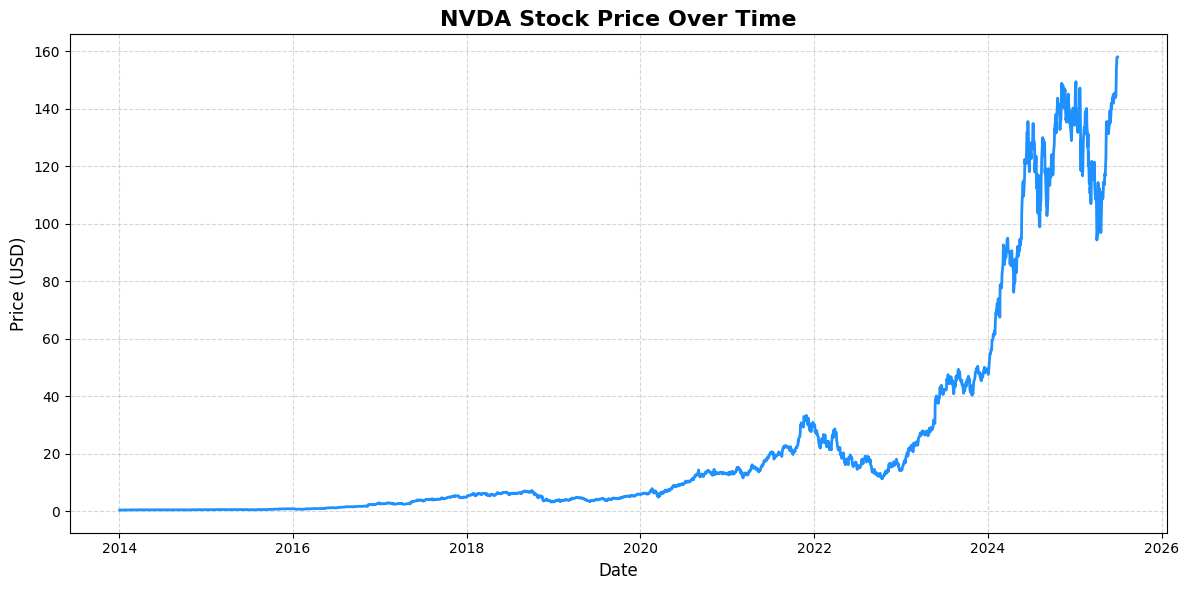

In [11]:
ticker = 'NVDA'
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[ticker], color='dodgerblue', linewidth=2)

plt.title(f'{ticker} Stock Price Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

In [12]:
df['year']= df.index.year
df['month'] = df.index.month
df['weekday'] = df.index.weekday
df['date'] = df.index.date

In [13]:
df = pd.melt(df, 
        id_vars=['year','month','weekday','date'], 
        var_name='ticker', value_name='close_price'
       )

In [14]:
df.sort_values(['ticker','date'], inplace=True)
df.head()

,year,month,weekday,date,ticker,close_price
0,2014,1,3,2014-01-02,A,36.524570
1,2014,1,4,2014-01-03,A,36.985916
2,2014,1,0,2014-01-06,A,36.803970
3,2014,1,1,2014-01-07,A,37.330299
4,2014,1,2,2014-01-08,A,37.941132


In [15]:
df['prev_close_price'] = df.groupby(['ticker'])['close_price'].shift(1)
# df['close_price'] / df['prev_close_price']

In [16]:
for days in [1,3,7,30,90,365]:
    df[f'growth_{days}d'] = df['close_price'] / df.groupby(['ticker'])['close_price'].shift(days)

In [17]:
# what we want to predict (for evaluation)
for days in [1,3,7,30,90,365]:
    df[f'growth_future_{days}d'] = df.groupby(['ticker'])['close_price'].shift(-days) / df['close_price']
    df[f'is_positive_growth_{days}d_future'] = np.where(df[f'growth_future_{days}d'] > 1, 1, 0)

In [18]:
df['roll_mean_10d']= df.groupby(['ticker'])['close_price'].rolling(10).mean().reset_index()['close_price']
df['roll_mean_20d']= df.groupby(['ticker'])['close_price'].rolling(20).mean().reset_index()['close_price']
df['growing_moving_average'] = np.where(df['roll_mean_10d'] > df['roll_mean_20d'], 1, 0)

In [19]:
# df['high_minus_low_relative'] = (df.High - df.Low) / df['Close']

In [20]:
# 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
# 252 triding days in a year
df['volatility'] = df.groupby(['ticker'])['growth_1d'].rolling(30).std().reset_index()['growth_1d'] * np.sqrt(252)

### Add other features

17:12:29 - cmdstanpy - INFO - Chain [1] start processing
17:12:30 - cmdstanpy - INFO - Chain [1] done processing


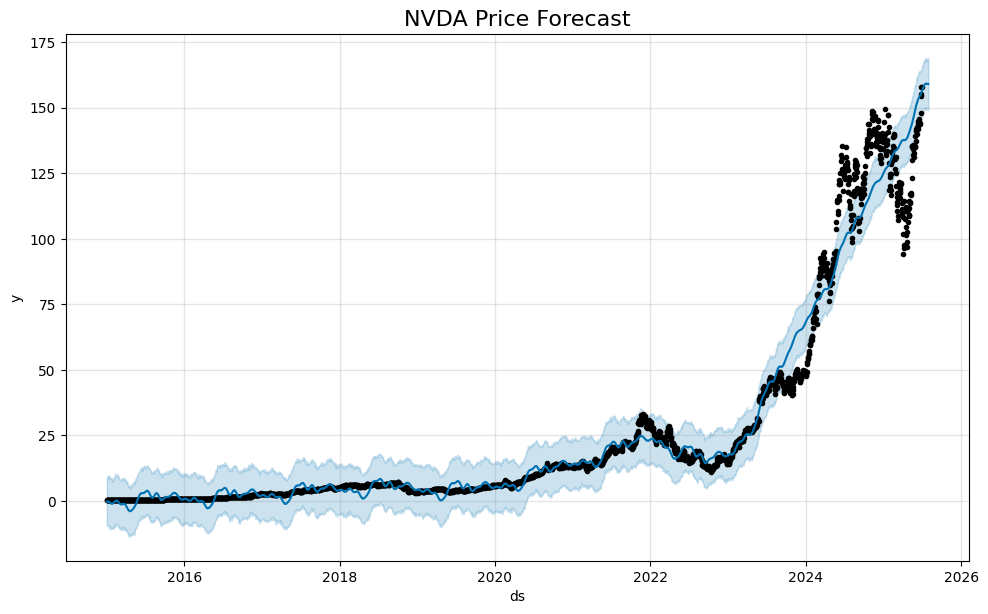

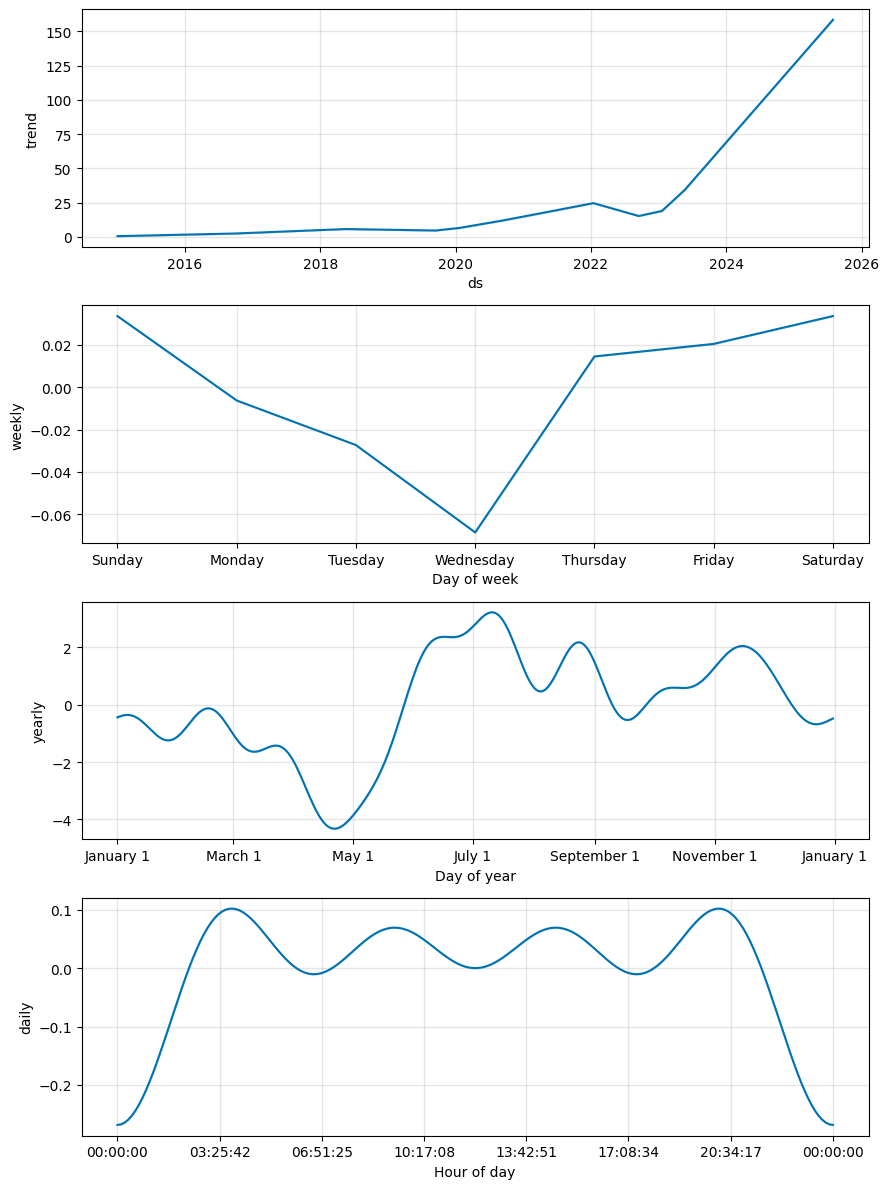

In [35]:
prophet_df = df.reset_index()[['Date', ticker]].rename(columns={'Date': 'ds', ticker: 'y'})
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)
future = model.make_future_dataframe(periods=30) 
forecast = model.predict(future)

fig1 = model.plot(forecast)
plt.title(f"{ticker} Price Forecast", fontsize=16)
plt.show()

fig2 = model.plot_components(forecast)
plt.show()

In [38]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
2658,2025-07-21,159.101664,149.836122,168.644332
2659,2025-07-22,159.062998,149.456867,167.619288
2660,2025-07-23,158.999037,149.328214,168.333638
2661,2025-07-24,159.057297,149.597695,168.816856
2662,2025-07-25,159.039684,149.802960,168.124859
2663,2025-07-26,159.033737,149.556434,168.136541
2664,2025-07-27,159.022347,149.279804,168.332170
2665,2025-07-28,158.981925,149.499371,167.537944
2666,2025-07-29,158.973960,148.977199,168.924994
2667,2025-07-30,158.962141,150.203922,167.864349


In [39]:
future_forecast = forecast[forecast['ds'] > prophet_df['ds'].max()]

In [43]:
nvda = yf.download([ticker], start="2025-07-01", end="2025-08-01", auto_adjust=True)['Close']

[*********************100%***********************]  1 of 1 completed


In [48]:
eval_df = future_forecast[['ds', 'yhat']].rename({'ds':'Date'}, axis=1).merge(nvda.reset_index())

In [51]:
eval_df['error'] = eval_df['yhat'] - eval_df[ticker]

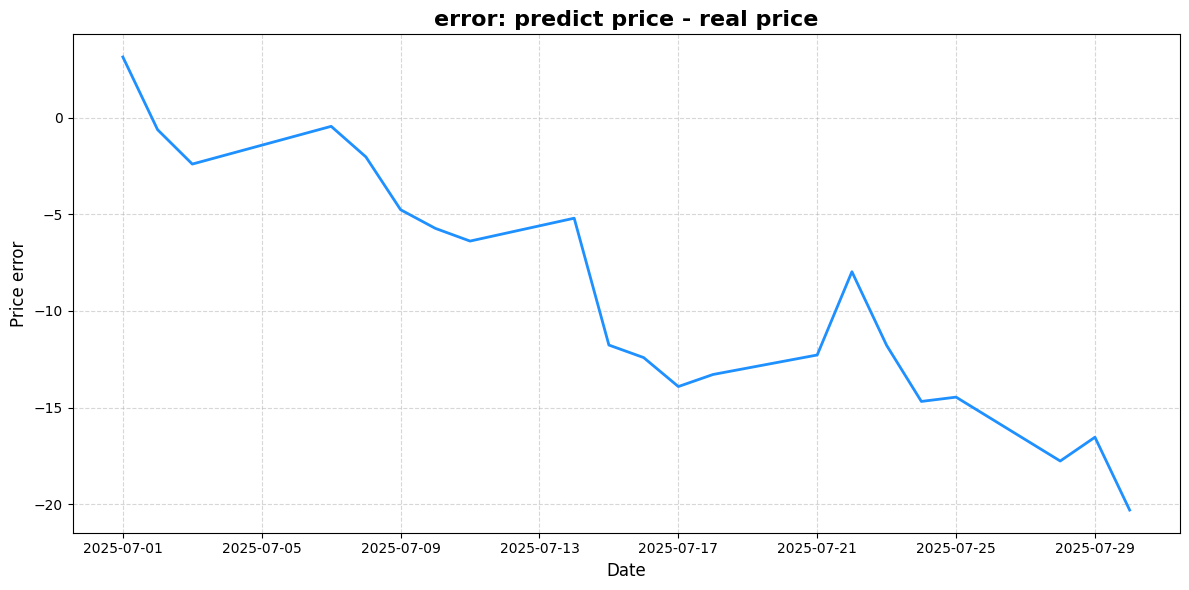

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(eval_df['Date'], eval_df['error'], color='dodgerblue', linewidth=2)

plt.title('error: predict price - real price', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price error', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()